In [469]:
# import necessary python libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily
pd.set_option("display.max_columns", 150)
import datetime
import seaborn as sns
import requests
import json
import urllib
import matplotlib.colors as colors

pd.set_option("display.max_rows", 101)

In [2]:

# for rochester / monroe county
monroe_records1217_ = pd.read_csv("data/monroe/2612_17.CSV", low_memory=False)
monroe_records18CUR = pd.read_csv("data/monroe/2618_CUR_utf8.CSV", low_memory=False)

In [143]:
monroe_records12_21 = pd.concat([monroe_records1217_,monroe_records18CUR],join="inner").reset_index()

In [224]:
monroe_records12_21.head(2)

,index,swis_code,county_name,muni_name,muni_type,school_code,school_name,print_key,vlg_print_key,total_av,vlg_total_av,seller_last_name,seller_first_name,buyer_last_name,buyer_first_name,street_nbr,street_name,atty_last_name,atty_first_name,atty_phone,swis_county,book,page,deed_date,sale_date,sale_price,personal_prop,cod_usable,rar_usable,arms_length_flag,front,depth,total_sale_acres,nbr_of_parcels,prop_class_last_roll,prop_class_desc_last_roll,prop_class_at_sale,prop_class_desc_at_sale,grid_east,grid_north,zip5,zip4,buyer_zip5,buyer_zip4,buyer_last_name2,buyer_street_nbr,buyer_street_name,buyer_city,buyer_state,part_parcel_flag,condo_flag,ownership_code,contract_date,second_swis,new_const_flag,vlg_rar_usable,roll_yr,rps_update_flag,rps_update_date,cor_update_flag,oth_update_flag,last_fm_date,rollmatch_flag,form_recd,load_date,assessor_reviewed_flag,cond_business_sale,cond_buyer_is_seller,cond_company_sale,cond_deed_type,cond_estate,cond_govt_sale,cond_interest_conv,cond_multiple_swis,cond_other,cond_relative_sale,cond_signif_change,cond_memo,vlg_signif_change_flag,Unnamed: 78,sale_yr,geometry
0,0,261400,Monroe,Rochester,2,261400.0,Rochester,120.360-0001-088.000,NaN,27500,0,TAMBURRINO PROPERTIES,NaN,12 JEFFERSON LLC,NaN,12,JEFFERSON AV 14611,NaN,NaN,NaN,26,11163,151,9/4/12,8/23/12,1,0,N,N,N,40,121,0.0,1,210.0,One Family Year-Round Residence,210.0,One Family Year-Round Residence,1403048,1151035,14611.0,NaN,14621.0,NaN,NaN,NaN,ARTHUR ST,ROCHESTER,NY,0,0,NaN,1/1/50,NaN,0,X,2012,1,11/21/12,0,0,12/6/12,1,1,11/16/12,1,0,0,0,1,0,0,0,0,0,0,0,SALE PRICE LESS THAN $10,0,NaN,12,POINT (1403048.000 1151035.000)
1,1,261400,Monroe,Rochester,2,261400.0,Rochester,107.650-0001-018.001/0000,NaN,85000,0,O,CALLAGHAN THOMAS,TSE,ALBERT & ANNA CHIN,548,MERCHANTS RD 14609,NaN,NaN,NaN,26,11163,188,9/4/12,8/31/12,130000,0,Y,Y,Y,30,120,0.0,1,220.0,Two Family Year-Round Residence,220.0,Two Family Year-Round Residence,1422583,1154577,14609.0,NaN,14609.0,NaN,NaN,548,MERCHANTS RD,ROCHESTER,NY,0,0,NaN,1/1/50,NaN,0,X,2012,1,11/21/12,0,0,12/6/12,1,1,11/16/12,1,0,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,12,POINT (1422583.000 1154577.000)


In [163]:
monroe_records12_21['sale_yr'] = monroe_records12_21['sale_date'].astype('str').str[-2:]

In [164]:
# geodataframe
monroe_records12_21_geo = gpd.GeoDataFrame(monroe_records12_21,
    geometry = gpd.points_from_xy(monroe_records12_21.grid_east,
    monroe_records12_21.grid_north))

monroe_records12_21_geo.crs = ('epsg:2262')

In [171]:
rochester = monroe_records12_21_geo[monroe_records12_21_geo.muni_name=='Rochester']

## 2. data cleaning: identifying out of bounds deeds



In [172]:
# loading in county boundaries to know the extent of Erie county 
ny_counties = gpd.read_file("data/ny_counties/Counties_Shoreline.shp")

monroe_cnty = ny_counties[ny_counties['NAME']=="Monroe"]
monroe_cnty = monroe_cnty.to_crs('epsg:2262')

rochester_boundary = gpd.read_file("data/rochester/rochesterboundary.geojson")

In [225]:
rochester_boundary.bounds

,minx,miny,maxx,maxy
0,1.383464e+06,1.132096e+06,1.428475e+06,1.192105e+06


In [176]:
# selecting just those records that fall within 2262 coordinate range for city of rochester boundaries
rochester_correct = rochester[(rochester.grid_north>1000000)&(rochester.grid_east>1200000)].copy()

In [177]:
print("min_east: ", rochester_correct.grid_east.min(),"max_east:", rochester_correct.grid_east.max())
print("min_north: ",rochester_correct.grid_north.max(),"max_north: ",rochester_correct.grid_north.max())

min_east:  1388790 max_east: 1427411
min_north:  1191816 max_north:  1191816


In [179]:
belowrochester = rochester[(rochester.grid_north<999999)&(rochester.grid_east<500000)].copy()

In [181]:
# clear that records are missing a preceeding 1 to match coordinate format for city of Rochester
belowrochester['grid_eastcor'] = "1"+belowrochester['grid_east'].astype(str)
belowrochester['grid_northcor'] = "1"+belowrochester['grid_north'].astype(str)

In [214]:
belowrochester_geo = gpd.GeoDataFrame(belowrochester,
    geometry = gpd.points_from_xy(belowrochester.grid_eastcor.astype(int),
    belowrochester.grid_northcor.astype(int)))

belowrochester_geo = belowrochester_geo[(belowrochester_geo.grid_northcor.astype(int)>1000000)&(belowrochester_geo.grid_eastcor.astype(int)>1200000)]
belowrochester_geo.grid_east = belowrochester_geo.grid_eastcor.astype(int)
belowrochester_geo.grid_north = belowrochester_geo.grid_northcor.astype(int)

belowrochester_geo = belowrochester_geo.drop(['grid_eastcor','grid_northcor'],axis=1)

In [216]:
rochester_located = pd.concat([rochester_correct,belowrochester_geo],join="inner")

In [223]:
# checking % coverage for city of Rochester
print("geolocated within bounds: ", rochester_located.shape)
print("original records: ",rochester.shape)
41779- 40142
1637/41779

geolocated within bounds:  (40142, 82)
original records:  (41779, 82)


0.039182364345723926

<AxesSubplot:>

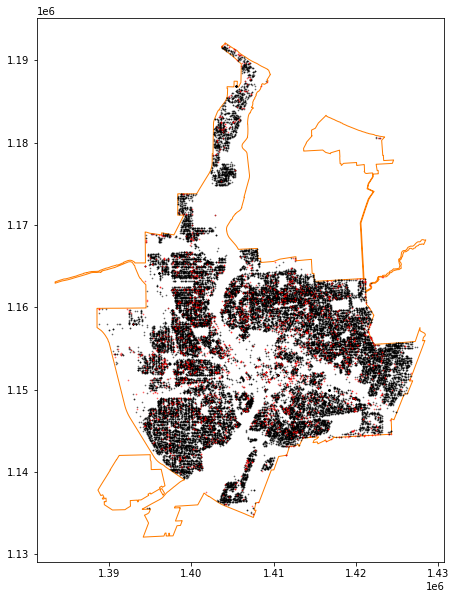

In [212]:
# base = monroe_cnty.plot(figsize=(10,10),color='#fff',edgecolor="#FF7C00")
base = rochester_boundary.plot(figsize=(10,10),color="#fff",edgecolor="#FF7C00")
rochester_correct.plot(ax=base,color='black',markersize=0.5,alpha=0.5)
# rochester_offleft_geo.plot(ax=base)
belowrochester_geo.plot(ax=base,color="red",markersize=0.5,alpha=0.5)

## 3. Initial investor classification and trends

In [230]:
sellercols = ['seller_first_name','seller_last_name']
buyercols = ['buyer_first_name','buyer_last_name']

# creating combined seller/buyer columns with first and last names
# rochester
rochester_located['seller_all'] = rochester_located[sellercols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
rochester_located['buyer_all'] = rochester_located[buyercols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)



In [231]:
rochester_located['prop_class_at_sale'] = pd.to_numeric(rochester_located['prop_class_at_sale'],downcast='float')

### Selecting just residential properties. Property classificiation codes for NY state available [here](https://www.tax.ny.gov/research/property/assess/manuals/prclas.htm#residential)
codes used:  
210 	One family year-round residence  
220 	Two family year-round residence  
270     Mobile home  

In [261]:

# monroe county
roch_res_deeds = rochester_located.loc[(rochester_located['prop_class_at_sale']==210.0)|
                                       (rochester_located['prop_class_at_sale']==215.0)|
                                       (rochester_located['prop_class_at_sale']==220.0)|
                                       (rochester_located['prop_class_at_sale']==270.0)]

# arms length sale filter
roch_res_allowed = roch_res_deeds.loc[(roch_res_deeds['arms_length_flag']=='Y')]


In [262]:
# print("erie residential, arms length total: ",eriedeeds12_21_res_arms.shape)
print("monroe residential, arms length total: ",roch_res_allowed.shape)

print("monroe residential, arms length total: ",roch_res_deeds.shape)


monroe residential, arms length total:  (17893, 84)
monroe residential, arms length total:  (33648, 84)


## classifying based on grantee name 

In [355]:
# investor classification ROCHESTER/MONROE CNTY
# selecting investors by grantee name
inv_roch = roch_res_allowed['buyer_all'].str.contains(
    'LLC|LP|LIMITED PARTNERSHIP|CORP|CORPORATION|INC|COMPANY|LIMITED PARTNE|L P|L L C|PARTNERSHIP|LTD|TRUST|MANAGEMENT|PROPERTIES|RENTAL'
    ,regex=True)

# converting investors series to dataframe
inv_roch = inv_roch.to_frame()

# merging with deeds
deeds_inv = roch_res_allowed.merge(
    inv_roch, left_index=True, right_index = True)
deeds_inv = deeds_inv_roch.dropna(subset=['buyer_all_x'])

# creating a count column to allow grouping and count 
# for investor and owner by year 
deeds_inv['inv'] = deeds_inv['buyer_all_y'].apply(lambda x: 1 if x == True else 0)
deeds_inv['occ'] = deeds_inv['buyer_all_y'].apply(lambda x: 1 if x == False else 0)

# dropping duplicate object ids from the dataset
# deeds_inv = deeds_inv.drop_duplicates(subset="objectid")

# ### running including non arms length sales

# selecting investors by grantee name
inv_nonarms_roch = roch_res_deeds['buyer_all'].str.contains(
    'LLC|LP|LIMITED PARTNERSHIP|CORP|CORPORATION|INC|COMPANY|LIMITED PARTNE|L P|L L C|PARTNERSHIP|LTD|TRUST|MANAGEMENT|PROPERTIES|RENTAL'
    ,regex=True)

# converting investors series to dataframe
inv_nonarms_roch = inv_nonarms_roch.to_frame()

# merging with deeds
deeds_inv_nonarms_roch = roch_res_deeds.merge(
    inv_nonarms_roch, left_index=True, right_index = True)
deeds_inv_nonarms_roch = deeds_inv_nonarms_roch.dropna(subset=['buyer_all_x'])

# creating a count column to allow grouping and count 
# for investor and owner by year 
deeds_inv_nonarms_roch['inv'] = deeds_inv_nonarms_roch['buyer_all_y'].apply(lambda x: 1 if x == True else 0)
deeds_inv_nonarms_roch['occ'] = deeds_inv_nonarms_roch['buyer_all_y'].apply(lambda x: 1 if x == False else 0)

# dropping duplicate object ids from the dataset
# deeds_inv = deeds_inv.drop_duplicates(subset="objectid")

In [356]:
# creating a unique ID for each deed
deeds_inv = deeds_inv.reset_index()
deeds_inv = deeds_inv.drop(columns='index')
deeds_inv = deeds_inv.rename(columns={"level_0":"ID"})

### 3. Classifying investor purchases by multiple purchasers
Identifying grantees who purchased more than 2 properties in any one year period from the full set of non-investor classified deeds:

In [357]:
# finding multiple purchasers from the full set of non-investor classified deeds
# selecting from just the non llc llp deeds
occ = deeds_inv.loc[deeds_inv['occ']==1].copy()

In [358]:
# getting all deeds from purchasers who are associated with more than one deed
multiple_purchasers = occ.groupby(
    "buyer_all_x").filter(lambda s: s['ID'].count()>=2)

In [359]:
multiple_purchasers['deed_date_dt'] = pd.to_datetime(multiple_purchasers['deed_date'], format='%m/%d/%y')

In [360]:
multiple_purchasers.columns

Index(['ID', 'swis_code', 'county_name', 'muni_name', 'muni_type',
       'school_code', 'school_name', 'print_key', 'vlg_print_key', 'total_av',
       'vlg_total_av', 'seller_last_name', 'seller_first_name',
       'buyer_last_name', 'buyer_first_name', 'street_nbr', 'street_name',
       'atty_last_name', 'atty_first_name', 'atty_phone', 'swis_county',
       'book', 'page', 'deed_date', 'sale_date', 'sale_price', 'personal_prop',
       'cod_usable', 'rar_usable', 'arms_length_flag', 'front', 'depth',
       'total_sale_acres', 'nbr_of_parcels', 'prop_class_last_roll',
       'prop_class_desc_last_roll', 'prop_class_at_sale',
       'prop_class_desc_at_sale', 'grid_east', 'grid_north', 'zip5', 'zip4',
       'buyer_zip5', 'buyer_zip4', 'buyer_last_name2', 'buyer_street_nbr',
       'buyer_street_name', 'buyer_city', 'buyer_state', 'part_parcel_flag',
       'condo_flag', 'ownership_code', 'contract_date', 'second_swis',
       'new_const_flag', 'vlg_rar_usable', 'roll_yr', 'rps_upd

In [361]:
columns_multi = ['ID','seller_all','buyer_all_x',
                 'deed_date_dt','street_nbr','street_name']
multiple_purchase_simple = multiple_purchasers[columns_multi].copy()


In [362]:

multiple_purchase_simple[
    'elapsed'] = multiple_purchase_simple.sort_values(
    ['buyer_all_x','deed_date_dt']).groupby(
    'buyer_all_x')['deed_date_dt'].diff()

# converting timedelta column to an int type 
# to make it possible to filter below
multiple_purchase_simple[
    'elapsed_days'] = multiple_purchase_simple[
    'elapsed'].dt.days


In [363]:
# filtering for deeds from grantees who purchased two properties within 1 year of each other
multiple_purchaser_simple = multiple_purchase_simple.groupby('buyer_all_x').filter(
    lambda x: x['elapsed_days'].min() <= 365)
multiple_purchaser_simple['multi_invest'] = 1

## 4. merging multiple purchase investors back with full set of deeds

Compiling a comprehensive classification of investor purchases 

In [366]:
deeds_multi = deeds_inv.merge(
    multiple_purchaser_simple, left_on="ID", right_on="ID",how="left")


In [367]:
deeds_multi["investor_all"] = deeds_multi['inv'] + deeds_multi["multi_invest"].fillna(0)
deeds_multi['owner_occup'] = deeds_multi['investor_all'].apply(lambda x: 0 if x == 1 else 1)

In [368]:
# Saving classified deeds to speed up future processing time 
deeds_for_save = deeds_multi.copy()
deeds_for_save['elapsed'] = deeds_for_save['elapsed'].fillna(pd.Timedelta('999 days'))


In [369]:
# saving final list of deeds

deeds_for_save.to_csv("data/processed/deeds_12_21_classified.csv")

## time series plots

In [380]:
deeds = pd.read_csv("data/processed/deeds_12_21_classified.csv")
deeds_geo = gpd.GeoDataFrame(deeds,
    geometry = gpd.points_from_xy(deeds.grid_east,
    deeds.grid_north))
deeds_geo.crs = ('epsg:2262')

In [536]:
# grouping to be able to plot

total_roch = deeds.groupby(['year']).agg({'count_field':'sum','inv':'sum','investor_all':'sum','occ':'sum'})
total_roch['inv_per_LLC'] = (total_roch['inv']/total_roch['count_field'])
total_roch['inv_per'] = (total_roch['investor_all']/total_roch['count_field'])




In [537]:
total_roch

,count_field,inv,investor_all,occ,inv_per_LLC,inv_per
year,,,,,,
2012,1771,397.0,555.0,1374.0,0.224167,0.313382
2013,1943,456.0,617.0,1487.0,0.234689,0.317550
2014,2006,541.0,722.0,1465.0,0.269691,0.359920
2015,1947,502.0,696.0,1444.0,0.257833,0.357473
2016,1777,490.0,674.0,1285.0,0.275746,0.379291
2017,2045,508.0,695.0,1534.0,0.248411,0.339853
2018,2184,600.0,778.0,1581.0,0.274725,0.356227
2019,2110,506.0,659.0,1600.0,0.239810,0.312322
2020,2093,507.0,638.0,1586.0,0.242236,0.304826


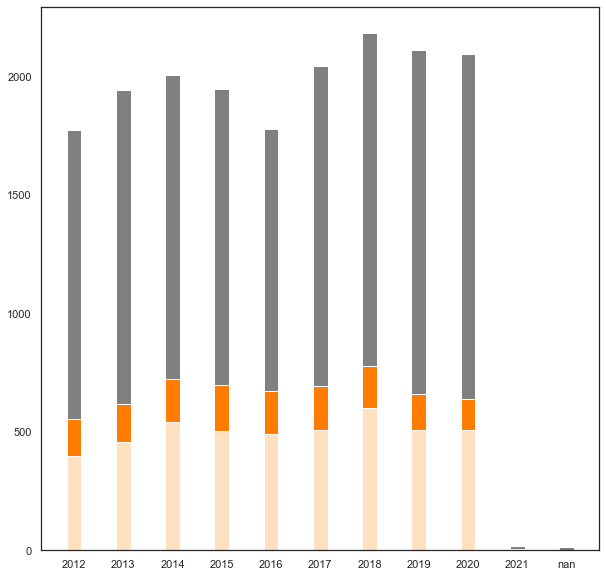

In [538]:
total_bar_rochester = total_roch.reset_index()
f, (ax1) = plt.subplots(1,1,figsize=(10, 10))
sns.set(style="white")

plt.bar(data=total_bar_rochester,x='year', 
            height='count_field',label='total purchases', color = 'grey',width=.3)
plt.bar(data=total_bar_rochester, x='year',
            height='investor_all',label='investor purchases', color = '#FF7C00', width=.3)
plt.bar(data=total_bar_rochester, x='year',
            height='inv',label='investor purchases', color = '#FFE1BF', width=.3)
plt.savefig('exports/rochester_totaldeeds.svg')

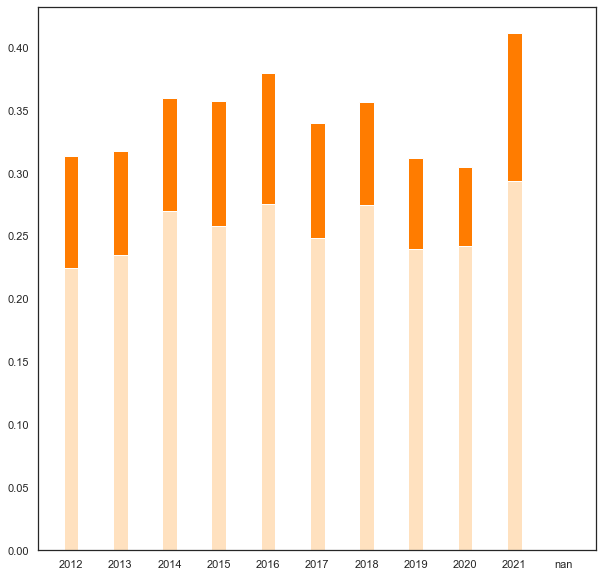

In [540]:
total_bar_rochester = total_roch.reset_index()
f, (ax1) = plt.subplots(1,1,figsize=(10, 10))
sns.set(style="white")

# plt.bar(data=total_bar_rochester,x='sale_yr', 
#             height='print_key',label='total purchases', color = 'grey',width=.3)
plt.bar(data=total_bar_rochester, x='year',
            height='inv_per',label='investor purchases', color = '#FF7C00', width=.3)
plt.bar(data=total_bar_rochester, x='year',
            height='inv_per_LLC',label='% investor purchases', color = '#FFE1BF', width=.3)
plt.savefig('exports/rochester_percentage_singleFamily.svg')

## Aggregating by block

In [240]:
blocksny = gpd.read_file("data/blocks/tabblock2010_36_pophu/tabblock2010_36_pophu.shp")
blocks_rochester = gpd.read_file("data/blocks/tabblock2010_36_rochester.geojson")

In [271]:
blocks_monroe = blocksny.loc[blocksny.COUNTYFP10 == '055']
blocks_monroe = blocks_monroe.to_crs("epsg:2262")


<AxesSubplot:>

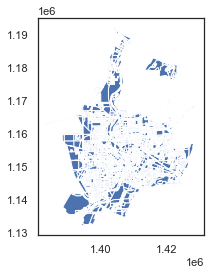

In [273]:
blocks_rochester.plot()

In [386]:
deeds_geo['count_field'] = 1

## defining residential parcels


In [387]:
all_parcels = gpd.read_file("data/rochester_tax_parcels/rochester_parcel_centroids.geojson")

In [395]:
res_parcels = all_parcels[(all_parcels.PROP_CLASS=='210')|
            (all_parcels.PROP_CLASS=='215')|
            (all_parcels.PROP_CLASS=='220')|
            (all_parcels.PROP_CLASS=='230')|
            (all_parcels.PROP_CLASS=='240')|
            (all_parcels.PROP_CLASS=='250')|
            (all_parcels.PROP_CLASS=='271')|
            (all_parcels.PROP_CLASS=='280')|
            (all_parcels.PROP_CLASS=='281')|
            (all_parcels.PROP_CLASS=='283')|
           (all_parcels.PROP_CLASS=='270')]

In [401]:
res_parcels_counts = res_parcels[['SBL', 'geometry']]
res_parcels_counts = res_parcels_counts.rename(columns = {'SBL':'parcel_num'})


In [415]:
print("all deeds12-20:",deeds_geo.shape)
print("total resparcels rochester: ", res_parcels_counts.shape)

all deeds12-20: (17906, 99)
resparcels rochester:  (52008, 2)


In [427]:
# creating a deed year column for grouping
deeds_geo['deed_date_dt'] = pd.to_datetime(deeds_geo['deed_date'], format='%m/%d/%y')
deeds_geo['year'] = pd.DatetimeIndex(deeds_geo['deed_date_dt']).year
deeds_geo["year"] = deeds_geo['year'].astype(str).str[:4]


In [428]:
# spatial join of deeds to blocks
deeds_b_12_20 = gpd.sjoin(blocks_rochester,deeds_geo, how='left', op='intersects').reset_index()

In [429]:
# getting counts of purchases by type for year block for each year
groupeddeeds_b_12_20 = deeds_b_12_20.groupby(["BLOCKID10","year"]).agg({'investor_all':'sum',
                                                     'owner_occup': 'sum','count_field':'count'}).unstack()


In [431]:
# unstacking the grouped columns
new_cols = [''.join(t) for t in groupeddeeds_b_12_20.columns]
groupeddeeds_b_12_20.columns = new_cols

In [433]:
# getting geometry column
b_rochesteer_geometry = blocks_rochester[['BLOCKID10','geometry']]

In [434]:
# merging grouped blocks with geometry field
groupeddeeds_b_12_20 = b_rochesteer_geometry.merge(groupeddeeds_b_12_20,
                                        how='left',
                                        left_on='BLOCKID10',
                                        right_on='BLOCKID10')

# converting to a geodataframe
groupeddeeds_b_12_20 = gpd.GeoDataFrame(groupeddeeds_b_12_20, 
                                      geometry=groupeddeeds_b_12_20['geometry'])

In [439]:
# joining residential parcels from land use to blocks to have count of parcels
res_b_00_10 = gpd.sjoin(blocks_rochester,res_parcels_counts, how='left', op='intersects').reset_index() 

# counts of residential parcels per block
res_count00 = res_b_00_10.groupby(["BLOCKID10"]).agg({'parcel_num':'count'}).reset_index()


In [440]:
# joining residential parcel count s and grouped deeds 
groupeddeeds_b_12_20_i = groupeddeeds_b_12_20.merge(res_count00,
                                                how='left',
                                                left_on='BLOCKID10',
                                                right_on='BLOCKID10')

In [443]:
# percent of purchases by block that are investor purchases 

# percent of purchases by block that are investor purchases 2012
groupeddeeds_b_12_20_i['per_inv_2012'] = groupeddeeds_b_12_20_i.apply(
    lambda x: 0 if x['parcel_num'] == 0 else x['investor_all2012']/x['parcel_num'], axis=1)
# 2013
groupeddeeds_b_12_20_i['per_inv_2013'] = groupeddeeds_b_12_20_i.apply(
    lambda x: 0 if x['parcel_num'] == 0 else x['investor_all2013']/x['parcel_num'], axis=1)
# 2014
groupeddeeds_b_12_20_i['per_inv_2014'] = groupeddeeds_b_12_20_i.apply(
    lambda x: 0 if x['parcel_num'] == 0 else x['investor_all2014']/x['parcel_num'], axis=1)
# 2015
groupeddeeds_b_12_20_i['per_inv_2015'] = groupeddeeds_b_12_20_i.apply(
    lambda x: 0 if x['parcel_num'] == 0 else x['investor_all2015']/x['parcel_num'], axis=1)
# 2016
groupeddeeds_b_12_20_i['per_inv_2016'] = groupeddeeds_b_12_20_i.apply(
    lambda x: 0 if x['parcel_num'] == 0 else x['investor_all2016']/x['parcel_num'], axis=1)
# 2017
groupeddeeds_b_12_20_i['per_inv_2017'] = groupeddeeds_b_12_20_i.apply(
    lambda x: 0 if x['parcel_num'] == 0 else x['investor_all2017']/x['parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
groupeddeeds_b_12_20_i['per_inv_2018'] = groupeddeeds_b_12_20_i.apply(
    lambda x:0 if x['parcel_num'] == 0 else x['investor_all2018']/x['parcel_num'], axis=1)

groupeddeeds_b_12_20_i['per_inv_2019'] = groupeddeeds_b_12_20_i.apply(
    lambda x:0 if x['parcel_num'] == 0 else x['investor_all2019']/x['parcel_num'], axis=1)

groupeddeeds_b_12_20_i['per_inv_2020'] = groupeddeeds_b_12_20_i.apply(
    lambda x:0 if x['parcel_num'] == 0 else x['investor_all2020']/x['parcel_num'], axis=1)

In [444]:
# percent of purchases by block that are owner occupant purchases 

# percent of purchases by block that are owneroccupant purchases 2012
groupeddeeds_b_12_20_i['per_occ_2012'] = groupeddeeds_b_12_20_i.apply(
    lambda x: 0 if x['parcel_num'] == 0 else x['owner_occup2012']/x['parcel_num'], axis=1)
# 2013
groupeddeeds_b_12_20_i['per_occ_2013'] = groupeddeeds_b_12_20_i.apply(
    lambda x: 0 if x['parcel_num'] == 0 else x['owner_occup2013']/x['parcel_num'], axis=1)
# 2014
groupeddeeds_b_12_20_i['per_occ_2014'] = groupeddeeds_b_12_20_i.apply(
    lambda x: 0 if x['parcel_num'] == 0 else x['owner_occup2014']/x['parcel_num'], axis=1)
# 2015
groupeddeeds_b_12_20_i['per_occ_2015'] = groupeddeeds_b_12_20_i.apply(
    lambda x: 0 if x['parcel_num'] == 0 else x['owner_occup2015']/x['parcel_num'], axis=1)
# 2016
groupeddeeds_b_12_20_i['per_occ_2016'] = groupeddeeds_b_12_20_i.apply(
    lambda x: 0 if x['parcel_num'] == 0 else x['owner_occup2016']/x['parcel_num'], axis=1)
# 2017
groupeddeeds_b_12_20_i['per_occ_2017'] = groupeddeeds_b_12_20_i.apply(
    lambda x: 0 if x['parcel_num'] == 0 else x['owner_occup2017']/x['parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
groupeddeeds_b_12_20_i['per_occ_2018'] = groupeddeeds_b_12_20_i.apply(
    lambda x:0 if x['parcel_num'] == 0 else x['owner_occup2018']/x['parcel_num'], axis=1)

groupeddeeds_b_12_20_i['per_occ_2019'] = groupeddeeds_b_12_20_i.apply(
    lambda x:0 if x['parcel_num'] == 0 else x['owner_occup2019']/x['parcel_num'], axis=1)

groupeddeeds_b_12_20_i['per_occ_2020'] = groupeddeeds_b_12_20_i.apply(
    lambda x:0 if x['parcel_num'] == 0 else x['owner_occup2020']/x['parcel_num'], axis=1)

In [445]:
# list comprehension to be able to fill all NaN values with 0 so that morans i will work
var1020 = [i for i in groupeddeeds_b_12_20_i.columns]
var1020.remove('geometry')
groupeddeeds_b_12_20_i = groupeddeeds_b_12_20_i.fillna({f:0 for f in var1020})



In [446]:
groupeddeeds_b_12_20_i.to_file("data/processed/groupeddeeds_b_12_20_blocks_res.geojson",
                              driver="GeoJSON")

### 5. Assessing Global Spatial Autocorrelation

In [ ]:
## can read grouped deeds in from here.....
# groupeddeeds_b_12_20_i = gpd.read_file("data/processed/groupeddeeds_b_12_20_blocks_res.geojson",

In [447]:
from pysal.lib.weights import DistanceBand
from pysal.explore.esda.moran import Moran

/Users/darebrawley/anaconda3/envs/geo-2021/lib/python3.6/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/Users/darebrawley/anaconda3/envs/geo-2021/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [448]:
# creating spatial weight for 2012-2020 blocks
#  distance band with threshold of 1/2 mile
#  uses a binary method so everything within 1/2 mile gets weigh
weight_12_20 = DistanceBand.from_dataframe(groupeddeeds_b_12_20_i, threshold=2640)

/Users/darebrawley/anaconda3/envs/geo-2021/lib/python3.6/site-packages/pysal/lib/weights/util.py:804: UserWarning: There is one disconnected observation (no neighbors).
Island id: 650
  w = W(neighbors, weights, ids, **kwargs)
/Users/darebrawley/anaconda3/envs/geo-2021/lib/python3.6/site-packages/pysal/lib/weights/distance.py:783: UserWarning: There is one disconnected observation (no neighbors).
Island id: 650
  W.__init__(self, neighbors, weights, ids, silence_warnings=self.silence_warnings)


In [454]:
# ## 2010-2020
global_moran_12_20 = Moran.by_col(groupeddeeds_b_12_20_i,
       ['per_inv_2012','per_inv_2013','per_inv_2014','per_inv_2015',
       'per_inv_2016','per_inv_2017','per_inv_2018',
    'per_inv_2019','per_inv_2020'],w=weight_12_20, inplace=False)

In [456]:
keep1020 = ['per_inv_2012_moran', 'per_inv_2012_p_sim',
       'per_inv_2013_moran', 'per_inv_2013_p_sim', 'per_inv_2014_moran',
       'per_inv_2014_p_sim', 'per_inv_2015_moran', 'per_inv_2015_p_sim',
       'per_inv_2016_moran', 'per_inv_2016_p_sim', 'per_inv_2017_moran',
       'per_inv_2017_p_sim', 'per_inv_2018_moran', 'per_inv_2018_p_sim',
           'per_inv_2019_moran', 'per_inv_2019_p_sim','per_inv_2020_moran', 'per_inv_2020_p_sim']
global_moran_12_20 = global_moran_12_20[keep1020]
global_moran_12_20 = global_moran_12_20.loc[0]

global_moran_12_20 = global_moran_12_20.to_frame()

global_moran_12_20 = global_moran_12_20.reset_index()

global_moran_12_20['year'] = global_moran_12_20['index'].str[8:12]
global_moran_12_20['type'] = global_moran_12_20['index'].str[-5:]

global_moran_12_20_table = global_moran_12_20.pivot(index='year',columns='type', values =0)

In [457]:
global_moran_12_20_table.transpose()

year,2012,2013,2014,2015,2016,2017,2018,2019,2020
type,,,,,,,,,
moran,0.05009,0.060564,0.045422,0.05217,0.055959,0.056525,0.041508,0.033458,0.06273
p_sim,0.00100,0.001000,0.001000,0.00100,0.001000,0.001000,0.001000,0.001000,0.00100


### 6. Calculating Local Morans i for blocks and percent investor purchases

In [529]:
from pysal.explore.esda.moran import Moran_Local, Moran

def fast_global_morans(dataset, column, spatial_weight):  
    print(column)
    moran_val = Moran(dataset[column].values,spatial_weight)
    print(".I: ", moran_val.I, "p value: ", moran_val.p_sim)
    return(moran_val)
        
def fast_local_morans(dataset, column, spatial_weight):  
    print(column)
    return(Moran_Local(dataset[column].values,spatial_weight))

In [530]:
moran2012_loc = fast_local_morans(groupeddeeds_b_12_20_i,'per_inv_2012',weight_12_20)
moran2013_loc = fast_local_morans(groupeddeeds_b_12_20_i,'per_inv_2013',weight_12_20)
moran2014_loc = fast_local_morans(groupeddeeds_b_12_20_i,'per_inv_2014',weight_12_20)
moran2015_loc = fast_local_morans(groupeddeeds_b_12_20_i,'per_inv_2015',weight_12_20)
moran2016_loc = fast_local_morans(groupeddeeds_b_12_20_i,'per_inv_2016',weight_12_20)
moran2017_loc = fast_local_morans(groupeddeeds_b_12_20_i,'per_inv_2017',weight_12_20)
moran2018_loc = fast_local_morans(groupeddeeds_b_12_20_i,'per_inv_2018',weight_12_20)
moran2019_loc = fast_local_morans(groupeddeeds_b_12_20_i,'per_inv_2019',weight_12_20)
moran2020_loc = fast_local_morans(groupeddeeds_b_12_20_i,'per_inv_2020',weight_12_20)



per_inv_2012
per_inv_2013
per_inv_2014
per_inv_2015
per_inv_2016
per_inv_2017
per_inv_2018
per_inv_2019
per_inv_2020


### 6b. Calculating Local Morans i for blocks and percent owner purchases

In [531]:
moran2012_loc_occ= fast_local_morans(groupeddeeds_b_12_20_i,'per_occ_2012',weight_12_20)
moran2013_loc_occ= fast_local_morans(groupeddeeds_b_12_20_i,'per_occ_2013',weight_12_20)
moran2014_loc_occ= fast_local_morans(groupeddeeds_b_12_20_i,'per_occ_2014',weight_12_20)
moran2015_loc_occ= fast_local_morans(groupeddeeds_b_12_20_i,'per_occ_2015',weight_12_20)
moran2016_loc_occ= fast_local_morans(groupeddeeds_b_12_20_i,'per_occ_2016',weight_12_20)
moran2017_loc_occ= fast_local_morans(groupeddeeds_b_12_20_i,'per_occ_2017',weight_12_20)
moran2018_loc_occ= fast_local_morans(groupeddeeds_b_12_20_i,'per_occ_2018',weight_12_20)
moran2019_loc_occ= fast_local_morans(groupeddeeds_b_12_20_i,'per_occ_2019',weight_12_20)
moran2020_loc_occ= fast_local_morans(groupeddeeds_b_12_20_i,'per_occ_2020',weight_12_20)



per_occ_2012
per_occ_2013
per_occ_2014
per_occ_2015
per_occ_2016
per_occ_2017
per_occ_2018
per_occ_2019
per_occ_2020


In [463]:
## 8. finding hh blocks for local morans i 

In [464]:
# function to create columns with True False values for whether a row is a HH cluster
# a given list of local morans objects
######
# note to self for later this could also be used to make a df with the quadrant values (i.e. hh,hl,ll,lh)
######
def hh_columns(dataframe,list_morans,names_morans,list_column_names):
# dataframe, is the dataframe you want to add columns to
# list_morans, is a list containing the local moran objects you want to compute for
# names_morans, is a list of the local moran objects as strings
# list_column_names, is a list of the column names you want to define

    def find_hh(list_morans,names_morans):
        list_hh = []
        keys = []
        for i,val in enumerate(list_morans):
#             print("morans values:"+ names_morans[i])
            keys.append(names_morans[i])
            sig = val.p_sim<0.05
            hh_geom = val.q==1*sig
            list_hh.append(hh_geom)
        dict_hh = {keys[i]:list_hh[i] for i in range(len(keys))}
        return(dict_hh)  

    def calc_hh_columns(dataframe,list_column_names,dict_hh):
        #dict_hh is a dictionary of values with morans T/F for whether the value is in a cluster
        new_df = dataframe.copy()
        dict_keys = []
        for key,value in dict_hh.items():
            dict_keys.append(key)
        for i,val in enumerate(list_column_names):
#             print("new column:" +val)
#             print("calculated from moran:" +dict_keys[i])
            new_df[val] = temp_dict[dict_keys[i]]
        return(new_df)
        
    temp_dict = find_hh(list_morans,names_morans)
    print("calculated hh clusters for given list of local morans i")
    return(calc_hh_columns(dataframe,list_column_names,temp_dict))
    

In [465]:
# Calculating for investors & owners 2010-2018
morans1020=[moran2012_loc,moran2012_loc_occ,
            moran2013_loc,moran2013_loc_occ,moran2014_loc,moran2014_loc_occ,moran2015_loc,moran2015_loc_occ,
            moran2016_loc,moran2016_loc_occ,moran2017_loc,moran2017_loc_occ,moran2018_loc,moran2018_loc_occ,
           moran2019_loc,moran2019_loc_occ,moran2020_loc,moran2020_loc_occ]
morans1020_names=['moran2012_loc',
                  'moran2012_loc_occ','moran2013_loc','moran2013_loc_occ','moran2014_loc','moran2014_loc_occ',
                  'moran2015_loc','moran2015_loc_occ','moran2016_loc','moran2016_loc_occ','moran2017_loc',
                  'moran2017_loc_occ','moran2018_loc','moran2018_loc_occ','moran2019_loc','moran2019_loc_occ',
                 'moran2020_loc','moran2020_loc_occ']
col_names1020=['inv_hh12','occ_hh12','inv_hh13','occ_hh13',
               'inv_hh14','occ_hh14','inv_hh15','occ_hh15','inv_hh16','occ_hh16','inv_hh17','occ_hh17',
               'inv_hh18','occ_hh18','inv_hh19','occ_hh19','inv_hh20','occ_hh20']
morans_hh_1020 = hh_columns(groupeddeeds_b_12_20_i,morans1020,morans1020_names,col_names1020)

calculated hh clusters for given list of local morans i


In [466]:
# calculating column showing overlap 2011-2020
morans_hh_1020['overlap12'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh12==True) 
                                                   and (x.occ_hh12==True) else 0,axis=1)
morans_hh_1020['overlap13'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh13==True) 
                                                   and (x.occ_hh13==True) else 0,axis=1)
morans_hh_1020['overlap14'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh14==True) 
                                                   and (x.occ_hh14==True) else 0,axis=1)
morans_hh_1020['overlap15'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh15==True) 
                                                   and (x.occ_hh15==True) else 0,axis=1)
morans_hh_1020['overlap16'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh16==True) 
                                                   and (x.occ_hh16==True) else 0,axis=1)
morans_hh_1020['overlap17'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh17==True) 
                                                   and (x.occ_hh17==True) else 0,axis=1)
morans_hh_1020['overlap18'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh18==True) 
                                                   and (x.occ_hh18==True) else 0,axis=1)
morans_hh_1020['overlap19'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh19==True) 
                                                   and (x.occ_hh19==True) else 0,axis=1)
morans_hh_1020['overlap20'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh20==True) 
                                                   and (x.occ_hh20==True) else 0,axis=1)


In [517]:
# 2012-2020
# finding blocks cumulative that were in one or another cluster
morans_hh_1020['overlap_all'] = morans_hh_1020.apply(lambda x: 1 if (x.overlap12==True) or
                                                     (x.overlap13==True) or
                                                     (x.overlap14==True) or
                                                     (x.overlap15==True) or
                                                     (x.overlap16==True) or
                                                     (x.overlap17==True) or
                                                     (x.overlap18==True) or
                                                     (x.overlap19==True) or
                                                     (x.overlap20==True) else 0,axis=1)


morans_hh_1020['own_all'] = morans_hh_1020.apply(lambda x: 1 if (x.occ_hh12==True) or
                                                     (x.occ_hh13==True) or
                                                     (x.occ_hh14==True) or
                                                     (x.occ_hh15==True) or
                                                     (x.occ_hh16==True) or
                                                     (x.occ_hh17==True) or
                                                     (x.occ_hh18==True) or
                                                     (x.occ_hh19==True) or
                                                     (x.occ_hh20==True) else 0,axis=1)

morans_hh_1020['inv_all'] = morans_hh_1020.apply(lambda x: 1 if (x.inv_hh12==True) or
                                                     (x.inv_hh13==True) or
                                                     (x.inv_hh14==True) or
                                                     (x.inv_hh15==True) or
                                                     (x.inv_hh16==True) or
                                                     (x.inv_hh17==True) or
                                                     (x.inv_hh18==True) or
                                                     (x.inv_hh19==True) or
                                                     (x.inv_hh20==True) else 0,axis=1)


## plotting basemap features

In [522]:
roads = gpd.read_file("data/context_base/roads_rochester.geojson")
water = gpd.read_file("data/context_base/water_rochester.geojson")
non_res = gpd.read_file("data/context_base/non_residential_areas_rochester.geojson")
bldg = gpd.read_file("data/context_base/buildings_rochester.geojson")
roads_formap = roads.loc[roads["RTTYP"] != 'M']
boundary = gpd.read_file("data/rochester/rochesterboundary.geojson")

## Plotting overlaps

In [470]:
inv_hh = ['#FFFFFF00','#FF7C00FF']
inv_hh_map = colors.ListedColormap(inv_hh)
occ_hh = ['#FFFFFF00','#AA29BEFF']
# occ_hh = [(255,255,255,0),(0,0,0,1)]

occ_hh_map = colors.ListedColormap(occ_hh)

over = ['#FFFFFF00','#00FFFFFF']
over_hh_map = colors.ListedColormap(over)

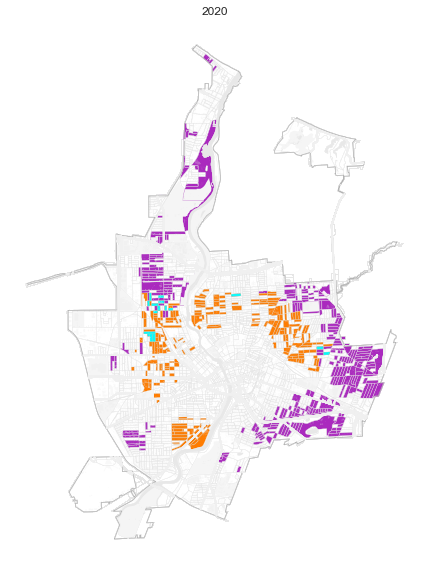

In [532]:
col_list = ["overlap12","overlap13","overlap14","overlap15","overlap16","overlap17","overlap18","overlap19","overlap20"]
ownhh = ["occ_hh12","occ_hh13","occ_hh14","occ_hh15","occ_hh16","occ_hh17","occ_hh18","occ_hh19","occ_hh20"]
invhh = ["inv_hh12","inv_hh13","inv_hh14","inv_hh15","inv_hh16","inv_hh17","inv_hh18","inv_hh19","inv_hh20"]
years = ['2012','2013','2014','2015','2016','2017','2018','2019','2020']
# names = ["res_overlap11","res_overlap12","res_overlap13","res_overlap14","res_overlap15","res_overlap16","res_overlap17","res_overlap18","res_overlap19","res_overlap20"]

fig, ax = plt.subplots(figsize=(10,10))
# morans_hh_0010.plot(color='white',edgecolor='#E6E6E6',linewidth=0.1,ax=ax,)

# occ_00_06.plot(column="occ_00_06",cmap=occ_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
# inv_00_06.plot(column="inv_00_06",cmap=inv_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax,alpha=0.9)
for i,val in enumerate(col_list):
    boundary.plot(color='#fff',edgecolor=None,ax=ax)
    morans_hh_1020.plot(column=ownhh[i],cmap=occ_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
    morans_hh_1020.plot(column=invhh[i],cmap=inv_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
    morans_hh_1020.plot(column=val,cmap=over_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')
    bldg.plot(ax=ax,edgecolor='none',color='#e8e8e850',alpha=0.3)

    water.plot(ax=ax, color="#e8e8e8", edgecolor='none', );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    boundary.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)

# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# plt.savefig("test.svg")
    ax.set_title(years[i])
    ax.set_axis_off()
    plt.savefig('exports/'+col_list[i]+'.png',dpi=300,format='png')

# plt.show()
# plt.savefig("../05_drawings/morans/hh_0006.png",dpi=500)


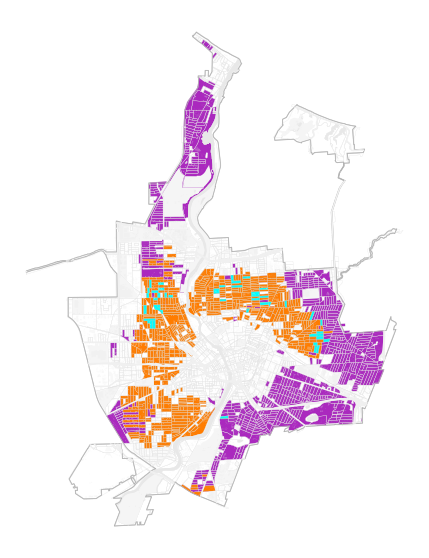

In [533]:
# 2011 - 2020 all overlaps

fig, ax = plt.subplots(figsize=(10,10))

# wards.plot(color='#fff',edgecolor=None,ax=ax)
boundary.plot(color='#fff',edgecolor="#D2D2D2",ax=ax)
morans_hh_1020.plot(column="own_all",cmap=occ_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
morans_hh_1020.plot(column="inv_all",cmap=inv_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
morans_hh_1020.plot(column="overlap_all",cmap=over_hh_map,edgecolor='#E6E6E6',linewidth=0.1,ax=ax)
non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')    
bldg.plot(ax=ax,edgecolor='none',color='#e8e8e850',alpha=0.3)

water.plot(ax=ax, color="#e8e8e8", edgecolor='none', );
roads_formap.plot(ax=ax, color="#F0F0F0",);
boundary.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)
# ax.set_title(years[i])
ax.set_axis_off()
plt.savefig('exports/2012-2020overlaps.png',dpi=300,format='png')

# plt.show()
# plt.savefig("../05_drawings/morans/hh_0006.png",dpi=500)


## 9. custom lisa cluster function to change colors

Defines colors as orange and blue cmap

In [473]:
def lisa_cluster_cust(colors5_list,moran_loc, gdf, p=0.05, ax=None,
                 legend=True, legend_kwds=None, **kwargs,):
    """
    Create a LISA Cluster map

    Parameters
    ----------
    colors5_list : list of str
        List of colours - must be in order [HH,HL,LH,LL,n/s]
        e.g. ['#d7191c', '#fdae61', '#abd9e9',
        '#2c7bb6', 'lightgrey']
    moran_loc : esda.moran.Moran_Local or Moran_Local_BV instance
        Values of Moran's Local Autocorrelation Statistic
    gdf : geopandas dataframe instance
        The Dataframe containing information to plot. Note that `gdf` will be
        modified, so calling functions should use a copy of the user
        provided `gdf`. (either using gdf.assign() or gdf.copy())
    p : float, optional
        The p-value threshold for significance. Points will
        be colored by significance.
    ax : matplotlib Axes instance, optional
        Axes in which to plot the figure in multiple Axes layout.
        Default = None
    legend : boolean, optional
        If True, legend for maps will be depicted. Default = True
    legend_kwds : dict, optional
        Dictionary to control legend formatting options. Example:
        ``legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (0.92, 1.05)}``
        Default = None
    **kwargs : keyword arguments, optional
        Keywords designing and passed to geopandas.GeoDataFrame.plot().

    Returns
    -------
    fig : matplotlip Figure instance
        Figure of LISA cluster map
    ax : matplotlib Axes instance
        Axes in which the figure is plotted

    Examples
    --------
    Imports
    
    >>> import matplotlib.pyplot as plt
    >>> from libpysal.weights.contiguity import Queen
    >>> from libpysal import examples
    >>> import geopandas as gpd
    >>> import matplotlib.colors as colors
    >>> from esda.moran import Moran_Local
    >>> from splot.esda import lisa_cluster

    Data preparation and statistical analysis
    
    >>> link = examples.get_path('Guerry.shp')
    >>> gdf = gpd.read_file(link)
    >>> y = gdf['Donatns'].values
    >>> w = Queen.from_dataframe(gdf)
    >>> w.transform = 'r'
    >>> moran_loc = Moran_Local(y, w)

    Plotting
    
    >>> fig = lisa_cluster(moran_loc, gdf)
    >>> plt.show()
    
    """
    def moran_hot_cold_spots(moran_loc, p=0.05):
        sig = 1 * (moran_loc.p_sim < p)
        HH = 1 * (sig * moran_loc.q == 1)
        LL = 3 * (sig * moran_loc.q == 3)
        LH = 2 * (sig * moran_loc.q == 2)
        HL = 4 * (sig * moran_loc.q == 4)
        cluster = HH + LL + LH + HL
        return cluster

    cluster = moran_hot_cold_spots(moran_loc, p)

    cluster_labels = ['ns', 'HH', 'LH', 'LL', 'HL']
    labels = [cluster_labels[i] for i in cluster]
    
    # define ListedColormap
    hmap = colors.ListedColormap(colors5_list)

    if ax is None:
        figsize = kwargs.pop('figsize', None)
        fig, ax = plt.subplots(1, figsize=figsize)
    else:
        fig = ax.get_figure()

    gdf.assign(cl=labels).plot(column='cl', categorical=True,
                               k=2, cmap=hmap, linewidth=0.1, ax=ax,
                                   edgecolor='#e6e6e6', legend=legend,
                               legend_kwds=legend_kwds, **kwargs)
    ax.set_axis_off()
#     ax.set_aspect('equal')
    return fig, ax

In [474]:
import matplotlib.colors as colors

## color format = HH,HL,LH,LL,ns
colors_owner =['#AA29BE','#F4AFFE','#F9F6C5','#C0D160','white']

# colors_owner_orig =['#AA29BE','#F4AFFE','#F7FFE1','#A2BE4F','white']
colors_investor = ['#FF7C00','#FFE1BF','#abd9e9','#6E93D1','white']

#ALT muted oragne/blue
# colors_investor = ['#E6A554','#F9E0BB','#A5BDFF','#173878','white']

# lighter
# colors_owner =['#4E2C83','#8885bc','#91b597','#def0a7','white']


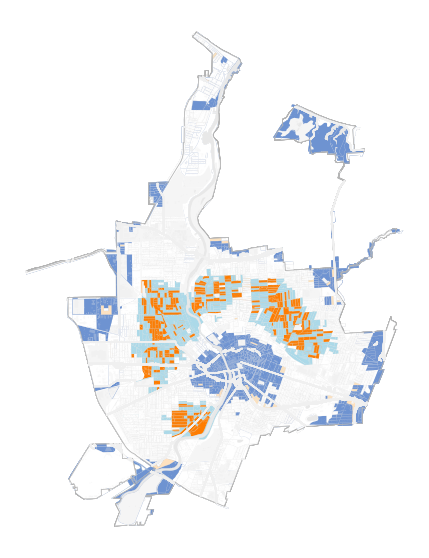

In [534]:
## method to batch export individual plots INVESTOR 

moran_list = [moran2012_loc,moran2013_loc, moran2014_loc,moran2015_loc, moran2016_loc,moran2017_loc, moran2018_loc,moran2019_loc,moran2020_loc]
files_list = ['inv2012.png','inv2013.png','inv2014.png','inv2015.png','inv2016.png','inv2017.png','inv2018.png','inv2019.png','inv2020.png']
years = ['2012','2013','2014','2015','2016','2017','2018','2019','2020']


fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
#     boundary.plot(color='#fff',edgecolor="#D2D2D2",ax=ax)
    lisa_cluster_cust(colors_investor, val, groupeddeeds_b_12_20_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')
    bldg.plot(ax=ax,edgecolor='none',color='#e8e8e850',alpha=0.3)

    water.plot(ax=ax, color="#e8e8e8", edgecolor='none', );
    roads_formap.plot(ax=ax, color="#F0F0F0",);
    boundary.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75)
    
#     ax.set_title(years[i],fontname="GT Zirkon")
    plt.savefig('exports/'+files_list[i],dpi=300,format='png')


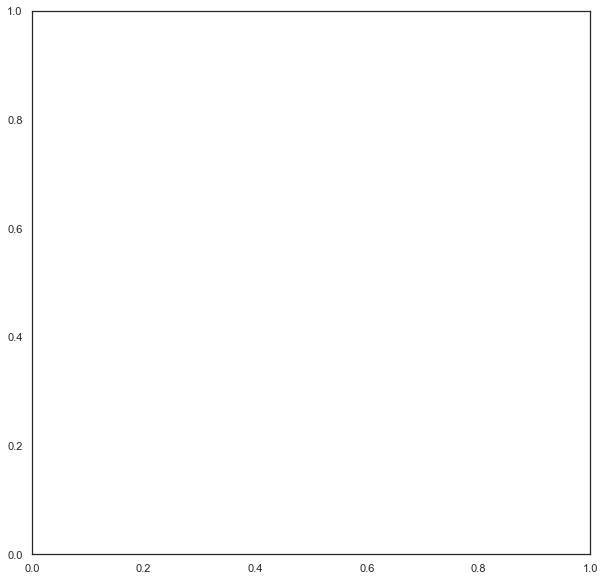

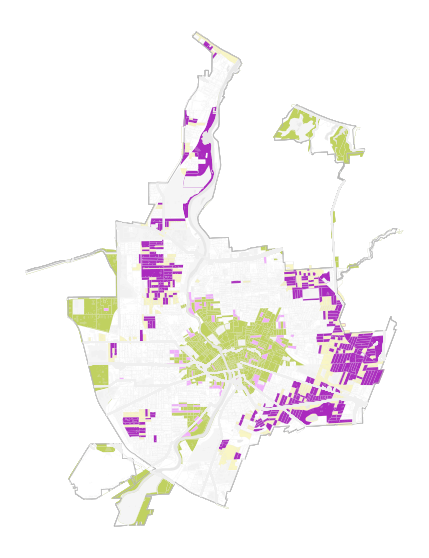

In [535]:
## method to batch export individual plots OWNER 

moran_list = [moran2012_loc_occ,moran2013_loc_occ, moran2014_loc_occ,moran2015_loc_occ, moran2016_loc_occ,moran2017_loc_occ, moran2018_loc_occ,moran2019_loc_occ,moran2020_loc_occ]
files_list = ['occ2012.png','occ2013.png','occ2014.png','occ2015.png','occ2016.png','occ2017.png','occ2018.png','occ2019.png','occ2020.png']
years = ['2012','2013','2014','2015','2016','2017','2018','2019','2020']

fig, ax = plt.subplots(figsize=(10,10))
fig, ax = plt.subplots(figsize=(10,10))
for i,val in enumerate(moran_list):
    boundary.plot(color='#fff',edgecolor="#D2D2D2",ax=ax)
    lisa_cluster_cust(colors_owner,val, groupeddeeds_b_12_20_i, p=0.05,ax=ax,legend=False)
    non_res.plot(ax=ax,edgecolor='none',color='#f5f5f5')
    bldg.plot(ax=ax,edgecolor='none',color='#e8e8e850',alpha=0.3)

    water.plot(ax=ax, color="#e8e8e8", edgecolor='none', );
    roads_formap.plot(ax=ax, color="#F0F0F0",);    
    boundary.plot(ax=ax, facecolor="none", edgecolor="#B4B4B4", linewidth=.75);
#     ax.set_title(years[i])
    plt.savefig('exports/'+files_list[i],dpi=300,format='png')
